In [1]:
import numpy as np
import pandas as pd
from utils import  amplitude_scaling, load_dataset, save_distance_matrix
from sklearn.neighbors import KNeighborsClassifier
from dtaidistance import dtw
from sklearn.metrics import classification_report 
from sklearn.model_selection import GridSearchCV
from utils import dtw_dist
from pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# Global Distances Features: PCA applied to the distance matrix

## sax-32

In [2]:
X_train_sax, y_train_sax, X_test_sax, y_test_sax = load_dataset('../dataset_ts/ts_data_sax32.npz')

In [3]:
# amplitude scaling
X_train_sax_scaled,y_train_sax_scaled = amplitude_scaling(X_train_sax,y_train_sax)
X_test_sax_scaled,y_test_sax_scaled = amplitude_scaling(X_test_sax,y_test_sax)

### PCA

In [4]:
from sklearn.decomposition import PCA

In [5]:
euc_mat_sax, dtw_mat_sax = (np.load('distances/sax_matrices.npz')['euclidean'], np.load('distances/sax_matrices.npz')['dtw'])

In [6]:
train_dtw_mat_sax = dtw_mat_sax[:7500,:7500]
test_dtw_mat_sax = dtw_mat_sax[7500:,:7500]

train_euc_mat_sax = euc_mat_sax[:7500,:7500]
test_euc_mat_sax = euc_mat_sax[7500:,:7500]

EUCLIDEAN

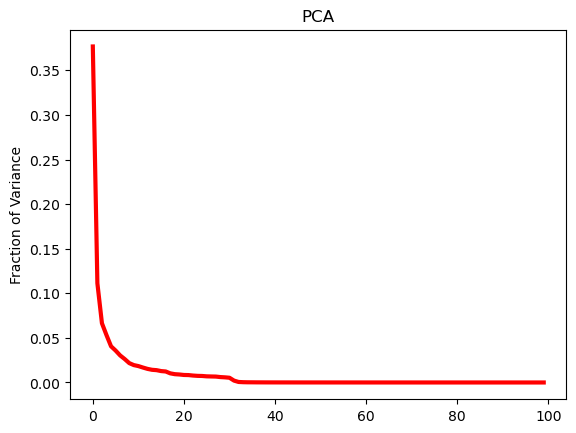

In [9]:
plt.plot(PCA(n_components=100).fit(train_euc_mat_sax).explained_variance_ratio_, lw=3, color='r', ms=2)
plt.title("PCA")
plt.ylabel("Fraction of Variance")
plt.show()


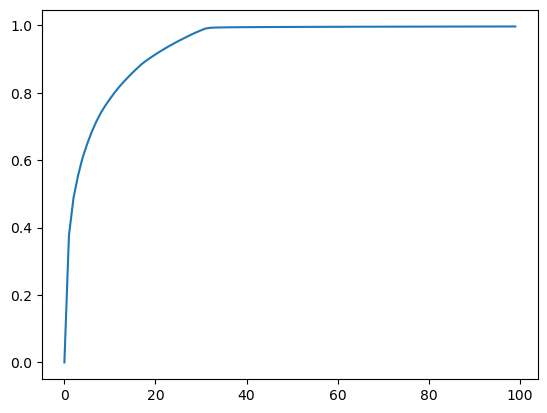

In [10]:
variance_ratio = PCA(n_components=100).fit(train_euc_mat_sax).explained_variance_ratio_
cumulative = [np.sum(variance_ratio[:i]) for i in range(variance_ratio.shape[0])]
plt.plot(cumulative)

20 components might be a reasonable choice

In [22]:
pca = PCA(n_components=16)
pca.fit(train_euc_mat_sax)
train_euc_pca_sax = pca.transform(train_euc_mat_sax)
test_euc_pca_sax = pca.transform(test_euc_mat_sax)

model selection:

In [23]:
parameters = {'n_neighbors': [1,5,10,15,20,30,40,50,60,80,100,125,150,200],
              'weights': ['distance', 'uniform'],
              'metric': ['euclidean', 'cosine', 'cityblock'],
              'n_jobs': [-1]
              }
knn = KNeighborsClassifier()
clf = GridSearchCV(
    knn, 
    parameters, 
    scoring='accuracy', 
    n_jobs=-1,
    refit=True,
    )
clf.fit(train_euc_pca_sax, y_train_sax_scaled)
print(clf.best_estimator_)
print(clf.best_params_)
print(clf.best_score_)

KNeighborsClassifier(metric='cosine', n_jobs=-1, n_neighbors=125,
                     weights='distance')
{'metric': 'cosine', 'n_jobs': -1, 'n_neighbors': 125, 'weights': 'distance'}
0.0956


In [25]:
parameters = {'criterion': ['gini', 'entropy','log_loss'],
              'min_samples_split': [32,64,128,200,300,400,500,600,700],
              'min_samples_leaf': [1,2,4,6,8,10,14,18,24,30,40,50,60,75,100],
              }
dtc = DecisionTreeClassifier(random_state=8)
clf = GridSearchCV(
    dtc, 
    parameters, 
    scoring='accuracy', 
    n_jobs=-1,
    refit=True,
    verbose=2
    )
clf.fit(train_euc_pca_sax, y_train_sax_scaled)
print(clf.best_estimator_)
print(clf.best_params_)
print(clf.best_score_)


Fitting 5 folds for each of 405 candidates, totalling 2025 fits
DecisionTreeClassifier(min_samples_leaf=30, min_samples_split=500,
                       random_state=8)
{'criterion': 'gini', 'min_samples_leaf': 30, 'min_samples_split': 500}
0.08453333333333332


In [24]:
clf = GaussianNB()
clf.fit(train_euc_pca_sax[:6000], y_train_sax_scaled[:6000])
print(clf.score(train_euc_pca_sax[6000:], y_train_sax_scaled[6000:]))

0.106


test:

In [26]:
# knn
clf = KNeighborsClassifier(n_neighbors=125,metric='cosine', n_jobs=-1, weights='distance')
clf.fit(train_euc_pca_sax, y_train_sax_scaled)
y_pred = clf.predict(test_euc_pca_sax)
print(classification_report(y_test_sax_scaled, y_pred))

              precision    recall  f1-score   support

           0       0.06      0.02      0.03       127
           1       0.05      0.02      0.03       133
           2       0.05      0.03      0.04       109
           3       0.11      0.37      0.17       139
           4       0.03      0.01      0.01       131
           5       0.17      0.10      0.13       135
           6       0.10      0.07      0.08       116
           7       0.12      0.06      0.08       145
           8       0.09      0.38      0.15       136
           9       0.10      0.04      0.06       119
          10       0.10      0.08      0.09       125
          11       0.04      0.03      0.04       123
          12       0.07      0.03      0.05       143
          13       0.09      0.25      0.13       118
          14       0.13      0.05      0.07       128
          15       0.04      0.02      0.02       112
          16       0.12      0.12      0.12       119
          17       0.04    

In [27]:
# decision tree
clf = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=30, min_samples_split=500)
clf.fit(train_euc_pca_sax, y_train_sax_scaled)
y_pred = clf.predict(test_euc_pca_sax)
print(classification_report(y_test_sax_scaled, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.04      0.04      0.04       127
           1       0.05      0.02      0.02       133
           2       0.07      0.04      0.05       109
           3       0.14      0.20      0.16       139
           4       0.04      0.05      0.04       131
           5       0.09      0.04      0.05       135
           6       0.05      0.03      0.03       116
           7       0.07      0.08      0.07       145
           8       0.16      0.26      0.20       136
           9       0.04      0.04      0.04       119
          10       0.12      0.04      0.06       125
          11       0.01      0.01      0.01       123
          12       0.00      0.00      0.00       143
          13       0.10      0.18      0.13       118
          14       0.07      0.05      0.06       128
          15       0.08      0.24      0.12       112
          16       0.07      0.10      0.08       119
          17       0.07    

In [28]:
# naive bayes
clf = GaussianNB()
clf.fit(train_euc_pca_sax, y_train_sax_scaled)
y_pred = clf.predict(test_euc_pca_sax)
print(classification_report(y_test_sax_scaled, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.06      0.04      0.05       127
           1       0.00      0.00      0.00       133
           2       0.08      0.03      0.04       109
           3       0.13      0.28      0.18       139
           4       0.20      0.05      0.08       131
           5       0.09      0.03      0.04       135
           6       0.13      0.09      0.11       116
           7       0.14      0.11      0.12       145
           8       0.12      0.33      0.17       136
           9       0.11      0.09      0.10       119
          10       0.12      0.04      0.06       125
          11       0.10      0.06      0.07       123
          12       0.08      0.03      0.04       143
          13       0.10      0.17      0.13       118
          14       0.07      0.08      0.07       128
          15       0.07      0.18      0.10       112
          16       0.08      0.13      0.10       119
          17       0.09    

DTW

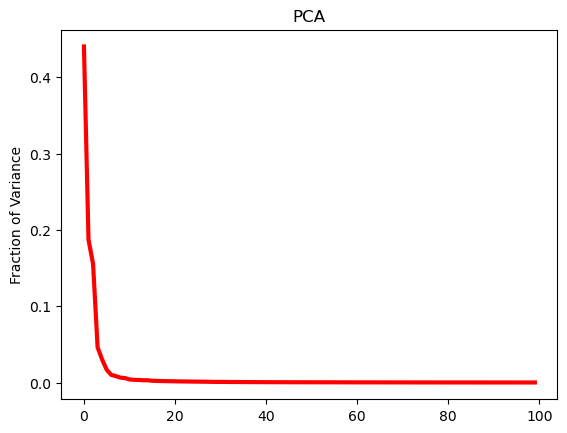

In [29]:
plt.plot(PCA(n_components=100).fit(train_dtw_mat_sax).explained_variance_ratio_, lw=3, color='r', ms=2)
plt.title("PCA")
plt.ylabel("Fraction of Variance")
plt.show()

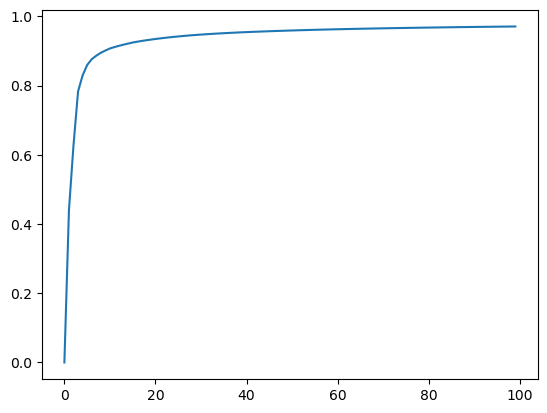

In [30]:
variance_ratio = PCA(n_components=100).fit(train_dtw_mat_sax).explained_variance_ratio_
cumulative = [np.sum(variance_ratio[:i]) for i in range(variance_ratio.shape[0])]
plt.plot(cumulative)

12 components might be a reasonable choice

In [40]:
pca = PCA(n_components=16)
pca.fit(train_dtw_mat_sax)
train_dtw_pca_sax = pca.transform(train_dtw_mat_sax)
test_dtw_pca_sax = pca.transform(test_dtw_mat_sax)

Model selection:

In [32]:
# knn
parameters = {'n_neighbors': [1,5,10,15,20,30,40,50,60,80,100,125,150,200],
              'weights': ['distance', 'uniform'],
              'metric': ['euclidean', 'cosine', 'cityblock'],
              'n_jobs': [-1]
              }
knn = KNeighborsClassifier()
clf = GridSearchCV(
    knn, 
    parameters, 
    scoring='accuracy', 
    n_jobs=-1,
    refit=True,
    )
clf.fit(train_dtw_pca_sax, y_train_sax_scaled)
print(clf.best_estimator_)
print(clf.best_params_)
print(clf.best_score_)

KNeighborsClassifier(metric='cosine', n_jobs=-1, n_neighbors=60,
                     weights='distance')
{'metric': 'cosine', 'n_jobs': -1, 'n_neighbors': 60, 'weights': 'distance'}
0.10106666666666668


In [52]:
# decision tree
parameters = {'criterion': ['gini', 'entropy','log_loss'],
              'min_samples_split': [32,64,128,200,300,400,500,600,700],
              'min_samples_leaf': [1,2,4,6,8,10,14,18,24,30,40,50,60,75,100],
              }
dtc = DecisionTreeClassifier(random_state=8)
clf = GridSearchCV(
    dtc, 
    parameters, 
    scoring='accuracy', 
    n_jobs=-1,
    refit=True,
    verbose=2
    )
clf.fit(train_dtw_pca_sax, y_train_sax_scaled)
print(clf.best_estimator_)
print(clf.best_params_)
print(clf.best_score_)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
DecisionTreeClassifier(criterion='entropy', min_samples_leaf=60,
                       min_samples_split=300, random_state=8)
{'criterion': 'entropy', 'min_samples_leaf': 60, 'min_samples_split': 300}
0.1489333333333333


In [41]:
# naive bayes
clf = GaussianNB()
clf.fit(train_dtw_pca_sax[:6000], y_train_sax_scaled[:6000])
print(clf.score(train_dtw_pca_sax[6000:], y_train_sax_scaled[6000:]))

0.10333333333333333


test:

In [42]:
# knn
clf = KNeighborsClassifier(n_neighbors=60,metric='cosine', n_jobs=-1, weights='distance')
clf.fit(train_dtw_pca_sax, y_train_sax_scaled)
y_pred = clf.predict(test_dtw_pca_sax)
print(classification_report(y_test_sax_scaled, y_pred))

              precision    recall  f1-score   support

           0       0.10      0.09      0.09       127
           1       0.07      0.05      0.06       133
           2       0.05      0.05      0.05       109
           3       0.24      0.22      0.23       139
           4       0.05      0.04      0.04       131
           5       0.08      0.08      0.08       135
           6       0.09      0.12      0.11       116
           7       0.13      0.08      0.10       145
           8       0.26      0.23      0.24       136
           9       0.11      0.10      0.11       119
          10       0.08      0.14      0.10       125
          11       0.04      0.03      0.03       123
          12       0.09      0.08      0.08       143
          13       0.14      0.22      0.17       118
          14       0.09      0.09      0.09       128
          15       0.06      0.08      0.07       112
          16       0.12      0.13      0.12       119
          17       0.05    

In [43]:
# decision tree
clf = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=60, min_samples_split=300)
clf.fit(train_dtw_pca_sax, y_train_sax_scaled)
y_pred = clf.predict(test_dtw_pca_sax)
print(classification_report(y_test_sax_scaled, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.06      0.09      0.07       127
           1       0.05      0.02      0.03       133
           2       0.06      0.09      0.07       109
           3       0.15      0.16      0.15       139
           4       0.07      0.02      0.04       131
           5       0.06      0.12      0.08       135
           6       0.04      0.03      0.04       116
           7       0.17      0.02      0.04       145
           8       0.13      0.19      0.15       136
           9       0.08      0.08      0.08       119
          10       0.08      0.05      0.06       125
          11       0.08      0.07      0.08       123
          12       0.09      0.14      0.11       143
          13       0.11      0.19      0.14       118
          14       0.08      0.05      0.06       128
          15       0.08      0.12      0.10       112
          16       0.18      0.10      0.13       119
          17       0.09    

In [44]:
# naive bayes
clf = GaussianNB()
clf.fit(train_dtw_pca_sax, y_train_sax_scaled)
y_pred = clf.predict(test_dtw_pca_sax)
print(classification_report(y_test_sax_scaled, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.09      0.02      0.04       127
           1       0.18      0.05      0.07       133
           2       0.08      0.02      0.03       109
           3       0.15      0.20      0.17       139
           4       0.18      0.08      0.11       131
           5       0.09      0.07      0.08       135
           6       0.02      0.01      0.01       116
           7       0.17      0.12      0.14       145
           8       0.18      0.29      0.22       136
           9       0.15      0.07      0.09       119
          10       0.11      0.16      0.13       125
          11       0.11      0.08      0.09       123
          12       0.08      0.07      0.08       143
          13       0.12      0.14      0.13       118
          14       0.12      0.18      0.14       128
          15       0.08      0.39      0.14       112
          16       0.09      0.10      0.09       119
          17       0.04    